In [1]:
#!pip install -q malariagen_data
#!pip install -q scikit-allel
#!pip install -q petl
#!pip install -q fontstyle
#!pip install -q pomegranate

In [1]:
import allel
import malariagen_data
import numpy as np
import pandas as pd
import dask
import dask.array as da
# silence some dask warnings
dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.diagnostics.progress import ProgressBar
import statistics as stat
import petl

In [2]:
import random
import itertools
#import plotly
import plotly.express as px

In [3]:
# plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib_venn as venn
import seaborn as sns
%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [4]:
plt.rcdefaults()
sns.reset_defaults()
rcParams = plt.rcParams
base_font_size = 10
rcParams['font.size'] = base_font_size
rcParams['axes.titlesize'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = 11
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
#rcParams['savefig.jpeg_quality'] = 100
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000
rcParams['figure.facecolor'] = 'w'

In [6]:
#Mounting Google Drive
#import os
#from google.colab import drive
#drive.mount("drive")

# make dir
#results_dir = "drive/MyDrive/Genomic/"
#os.makedirs(results_dir, exist_ok=True)

## access to data set

In [5]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
#ag3

#samples sets
sets = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C","1191-VO-MULTI-OLOUGHLIN-VMF00106",
        "1191-VO-MULTI-OLOUGHLIN-VMF00140", "1314-VO-BF-KIENTEGA-KIMA-BF-2104"]

df_samples = ag3.sample_metadata(sample_sets=sets)
df_samples.query('country == "Burkina Faso" and year==2012').groupby(['location', 'year', 'aim_species']).size()

location        year  aim_species                  
Bana Village    2012  coluzzii                         42
                      gambiae                          22
                      intermediate_gambiae_coluzzii     1
Pala            2012  coluzzii                         11
                      gambiae                          48
Souroukoudinga  2012  coluzzii                         29
                      gambiae                          28
dtype: int64

In [12]:
df_samples.query('country == "Burkina Faso"').to_csv('data_saved/bf_samples.csv')
df_samples.query('country == "Burkina Faso"').to_excel('data_saved/bf_samples.xlsx')


In [13]:
#samples sets
sets1 = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C","1191-VO-MULTI-OLOUGHLIN-VMF00106",
        "1191-VO-MULTI-OLOUGHLIN-VMF00140"]

bf_1_samples = ag3.sample_metadata(sample_sets=sets1)
bf_1_samples.query('country == "Burkina Faso"').to_excel('data_saved/bf_1_samples.xlsx')

In [8]:
def compute_gt(samples = sets, region = '2R', query='country == "Burkina Faso" and aim_species == "gambiae" and year==2012',
               loca_ = (48703664 , 48792262), filt = 'gamb_colu'):
    
    ## dict to add pos 
    dict_gt, dict_pos = {}, {}
    
    # df samples
    df_samples = ag3.sample_metadata(sample_sets=samples, sample_query=query)
    pops = df_samples.location.unique()

    #To access to the genotypes within the 2R chromosome
    chrom2R_gt = ag3.snp_calls(region=region, sample_sets=samples, sample_query=query)
    
    # SNP position in the 2R chromosome 
    snps_pos = allel.SortedIndex(chrom2R_gt['variant_position'].values)
    loc_region = snps_pos.locate_range(loca_[0] , loca_[1])
    
    #To the genomics dataset within the target region 
    dsx_gt = chrom2R_gt.sel(variants=loc_region)
    #To filter the SNP dataset and warp the dataset to GT array 
    filt_val = dsx_gt[f"variant_filter_pass_{filt}"].values 
    gt_filtered = allel.GenotypeDaskArray(dsx_gt["call_genotype"][filt_val].data)
    dict_gt['chrom2R_gt'], dict_gt['dsx_gt'], dict_gt['gt_filtered'] = chrom2R_gt, dsx_gt, gt_filtered
    dict_pos['snps_pos'], dict_pos['loc_region'] = snps_pos, loc_region

    ## Warp gt to array and count allel
    with ProgressBar():
        gt_filtered_arr = allel.GenotypeArray(gt_filtered)
        ac = gt_filtered.count_alleles(max_allele=3).compute()
    
    dict_gt['gt_filtered_arr'], dict_gt['ac'] = gt_filtered_arr, ac
    ## 
    # To get the variants positions within the target region in dsx
    is_variant = ac.is_variant()
    pos_df = dsx_gt['variant_position'][filt_val].compute()
    pos_ = allel.SortedIndex(pos_df["variant_position"].values) 
    dict_pos['is_variant'], dict_pos['pos_df'], dict_pos['pos_'] = is_variant, pos_df, pos_
    
    return dict_gt, dict_pos, pops


### An. gambiae GT data 

In [9]:
Ag_gt_2012, Ag_pos_2012, Ag_pop_2012 = compute_gt(query='country == "Burkina Faso" and aim_species == "gambiae" and year==2012')
Ag_gt_2017, Ag_pos_2017, Ag_pop_2017 = compute_gt(query='country == "Burkina Faso" and aim_species == "gambiae" and year==2017')

[########################################] | 100% Completed | 8.21 ss
[########################################] | 100% Completed | 9.22 ss
[########################################] | 100% Completed | 10.10 s
[########################################] | 100% Completed | 10.75 s


### An. coluzzii GT data 

In [10]:
Ac_gt_2012, Ac_pos_2012, Ac_pop_2012 = compute_gt(query='country == "Burkina Faso" and aim_species == "coluzzii" and year==2012')
Ac_gt_2017, Ac_pos_2017, Ac_pop_2017 = compute_gt(query='country == "Burkina Faso" and aim_species == "coluzzii" and year==2017')

[########################################] | 100% Completed | 9.09 ss
[########################################] | 100% Completed | 8.58 ss
[########################################] | 100% Completed | 15.30 s
[########################################] | 100% Completed | 14.22 s


## An. gambiae reference genome 

In [11]:
# dsx region
dsx_region = ('2R', 48703664, 48792262)

## reference genome
df_geneset = ag3.geneset().set_index("ID")
#df_geneset

## let's access to the reference transcript of the gene AGAP004050 
df_geneset.query("Parent == 'AGAP004050'")

## let's choose a transcripts
transcrit_id = ['AGAP004050-RA', 'AGAP004050-RB']

#transcrit_id

dsx_genset = df_geneset.loc[(df_geneset.index == 'AGAP004050')|
                           (df_geneset.index.isin(transcrit_id))|
                           (df_geneset.Parent.isin(transcrit_id))]
gene_id = list(dsx_genset.index)
dsx_genset.insert(8, 'gene_id', gene_id)
dsx_genset = dsx_genset.fillna(0) 
#dsx_genset

## Function to compute dsx diversity

In [12]:
## Function to compute transcript dataframe by transcripts
def transcript_dataset(data, transcript):
    'This function compute the dataset of each transcript'
    for idx in data.index:
        if idx == transcript:
            val = data.index.get_loc(idx)
            transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
    return transcript_data

## genset for each transcript
dsx_RA = transcript_dataset(dsx_genset, 'AGAP004050-RA')
dsx_RB = transcript_dataset(dsx_genset, 'AGAP004050-RB')

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated

In [13]:
access = ag3.is_accessible(region='2R', site_mask='gamb_colu')

In [14]:
def plot_transcripts(geneset, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None, xlim=None, exon_label='{}', spec_pos=None, region_name=None, int_reg=None, 
                     include_transcripts=None):
    """Plot all transcripts for one or all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 1))
    sns.despine(ax=ax, left=True, bottom=True)
        
    if title:
        ax.set_title(title, va='bottom')
    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene')").sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.gene_id).sort_values('gene_id')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            if include_transcripts is not None and transcript.gene_id not in include_transcripts:
                continue
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            
            if xlim is not None:
                start, stop = xlim
                text_y = y + height + (height / 10)
                if label_transcripts == 'right':
                    text_x = min(stop, transcript.end)
                    ha = 'right'
                else:
                    text_x = max(start, transcript.start)
                    ha = 'left'
                if label_transcripts:
                    if transcript.strand == '+':
                        text = '%s >' % transcript.gene_id
                    else:
                        text = '< %s' % transcript.gene_id
                    ax.text(text_x, text_y, text, ha=ha, va='bottom', size=6)
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.gene_id).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'gray')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.gene_id)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
                
            # keep track of CDS position
            cds_pos = 0
            
            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                
                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='darkgray', label='CDS')
                ax.add_patch(patch)
                
                # accumulate CDS positions
                cds_pos += width + 1  

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.gene_id).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height#* .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, color='darkred', label='UTR')
                ax.add_patch(patch)

            # plot exons
            if transcript.strand == '+':
                exons = exons.sort_values('start', ascending=True)
            else:
                exons = exons.sort_values('end', ascending=False)
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x
                exon_height = height#* .8
                exon_y = y + (height - exon_height) / 2
                patch = plt.Rectangle((x, exon_y), width, exon_height, facecolor='none', edgecolor='k', linewidth=0.01)
                ax.add_patch(patch)

                # label exons
                if label_exons == transcript.gene_id and xlim is not None:
#                     text_y = y - height/10
                    text_y = y + height/2
                    start, stop = xlim
                    if exon.end > start and exon.start < stop:
                        if exon.start < start:
                            text_x = (start + exon.end) / 2
                        elif exon.end > stop:
                            text_x = (exon.start + stop) / 2
                        else:
                            text_x = (exon.start + exon.end) / 2
                        s = exon_label.format(i + 1)
                        ax.text(text_x, text_y, s, ha='center', va='center', color='k', zorder=20)
    #plot specific region
    s=0
    for tr in sorted(geneset.Parent.unique()[2:]):
        s += -1
        gene_Ri = transcript_dataset(geneset, f'{tr}')
        if tr == sorted(geneset.Parent.unique()[2:])[-1]:
            if gene_Ri.end[1]>1373660 and spec_pos:
                ax.add_patch(Rectangle((spec_pos[0], s), spec_pos[1]-spec_pos[0], exon_height, edgecolor='darkgoldenrod', 
                                        fill=False, lw=1, label=f'{region_name}'))
            if int_reg:
                ax.add_patch(Rectangle((int_reg[0], s), int_reg[1]-int_reg[0], exon_height, edgecolor='magenta',
                                       fill=False, lw=1, label='interest region'))
        else:
            if gene_Ri.end[1]>1373660 and spec_pos:
                ax.add_patch(Rectangle((spec_pos[0], s), spec_pos[1]-spec_pos[0], exon_height, edgecolor='darkgoldenrod', 
                                        fill=False, lw=1))
            if int_reg:
                ax.add_patch(Rectangle((int_reg[0], s), int_reg[1]-int_reg[0], exon_height, edgecolor='magenta',
                                       fill=False, lw=1))
    ax.set_yticks([])
    if xlim:
        ax.set_xlim(*xlim)
        ax.set_xticks([])
        ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
        ax.autoscale(axis='y', tight=False)


In [15]:
plot_transcripts(dsx_RA)

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))


In [16]:
plot_transcripts(dsx_RB)

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))


In [17]:
def plot_diversity_windowed_mean(xlim=dsx_region[1:], ylim=(0, 0.15), pos=Ag_pos_2012['pos_'], ac=Ag_gt_2012['ac'], 
                                 window_size=20, start=48703664, stop=48792242, window_step=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2))
        sns.despine(ax=ax, offset=5)

    # plot diversity
    y, window,_ ,_ = allel.windowed_diversity(pos=pos, ac = ac, size=window_size, start=start, stop=stop)
    x = window.mean(axis=1)
    ax.fill_between(x, 0, y, color='k', alpha=.3)
    ax.plot(x, y, linestyle='-', marker=None, color='darkred', linewidth=0.4)
    ax.set_ylabel(r'$\theta_{\pi}$')
    ax.set_xlabel('Genome position (bp)')
    
    # tidy up
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
    
plot_diversity_windowed_mean()

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\1781534162.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


In [18]:
def plot_diversity(xlim=dsx_region[1:], pos=Ag_pos_2012['pos_'], ac= Ag_gt_2012['ac'], window_size=20, start=48703664, 
                   stop=48792242, window_step=None, xtick=True, ax=None, ylim=None):
    '''
    This function plot the Nucleotide diversity and conservation score in the same axe.
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 2))
        sns.despine(ax=ax, offset=5)
        # plot diversity
        y, window,_ ,_ = allel.windowed_diversity(pos=pos, ac = ac, size=window_size, start=start, stop=stop)
        x = window.mean(axis=1)
        ax.fill_between(x, 0, y , color='#8B7D6B', alpha=.3, label='Nucleotide diversity')
        ax.plot(x, y , linestyle='-', marker=None, color='k',linewidth=0.2)
        ax.set_ylabel(r'$\theta_{\pi}$')
        if ylim:
            ax.set_ylim(*ylim)
        else:
            ax.set_ylim(0,np.nanmax(y))
        #ax.set_xlabel(f'Chromosome 2R (bp)')
        # tidy up
        #ax1.legend(labels=[])
        ax.set_xlim(*xlim)
        if xtick:
            ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
            ax.set_xlabel(f'Chromosome 2R (bp)')
        else:
            ax.set_xticklabels([])
    else:
        sns.despine(ax=ax, offset=5)
        # plot diversity
        y, window,_ ,_ = allel.windowed_diversity(pos=pos, ac = ac, size=window_size, start=start, stop=stop)
        x = window.mean(axis=1)
        ax.fill_between(x, 0, y , color='#8B7D6B', alpha=.3, label='Nucleotide diversity')
        ax.plot(x, y , linestyle='-', marker=None, color='k', linewidth=0.2)
        ax.set_ylabel(r'$\theta_{\pi}$')
        if ylim:
            ax.set_ylim(*ylim)
        else:
            ax.set_ylim(0,np.nanmax(y))
        # tidy up
        ax.set_xlim(*xlim)
        if xtick:
            ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
            ax.set_xlabel(f'Chromosome 2R (bp)')
        else:
            ax.set_xticklabels([])
    
    # legend
    #fig.legend()

    
plot_diversity()

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


In [19]:
## dsx position  
loc_dsx = ('2R', 48703664, 48792262)
loc_ex1 = ('2R', 48787046, 48788460)
loc_ex2 = ('2R', 48784185, 48785629)
loc_ex3 = ('2R', 48747693, 48747737)
loc_ex4 = ('2R', 48715161, 48715295)
loc_ex5_ra = ('2R', 48711528, 48712794)
loc_ex5_rb = ('2R', 48712957, 48714648)
loc_ex6 = ('2R', 48703664, 48706331)

loc_ex5_ra_err = ('2R', 48710528, 48713794)
loc_ex5_rb_err = ('2R', 48711957, 48715648)

gd_site = ('2R', 48714420, 48714720)
gd_site1 = ('2R', 48714300, 48714800)
gds = ('2R', 48714637, 48714660)

In [20]:
def fig2_density(data = dsx_RA, xlim = dsx_region, pos=Ag_pos_2012['pos_'], ac=Ag_gt_2012['ac'],start=48703664, 
                 stop=48792242,window_size=100, window_step=None, ylim=None, figsize=(9, 3), exon_label='{}', 
                 stop1=None, xtick=True, spec_pos=None, region_name=None, int_reg=None, r1=0.1, r2=1.5, fig_name = None):
    '''
    This function plot the Nucleotide diversity, conservation score, the transcript 
    on the same axe.
    '''
    gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=(r1, r2))
    
    fig = plt.figure(figsize=figsize)
    
    # plot the gene model
    ax = fig.add_subplot(gs[0])
    plot_transcripts(data, ax=ax, xlim=xlim[1:], spec_pos=spec_pos, label_exons=f'{data.index[1]}', 
                     region_name=region_name, int_reg=int_reg, exon_label=exon_label)
    #plot stop
    if stop1:
        if type(stop1) == int:
            ax.axvline(x=stop1, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
        else:
            for stop_pos in stop1[0:-1]:
                ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--')
            ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
    ax.set_xlim(*xlim[1:])
    
    # plot diversity
    ax = fig.add_subplot(gs[1])
    plot_diversity(xlim=xlim[1:], pos=pos, ac= ac,  window_size=window_size, start=start, stop=stop, 
                   window_step=window_step, ax=ax, ylim=ylim, xtick=xtick) 
    ax.set_xlabel(f'Chromosome {xlim[0]} (pb)')
    
    #save fig
    if fig_name:
        fig.savefig(f'{fig_name}', dpi=300, bbox_inches='tight')

In [21]:
fig2_density(data=dsx_RB, figsize=(9, 3.25), xlim=loc_dsx,  window_size=20, exon_label='',  spec_pos=loc_ex4[1:], 
             region_name='Sex specific region', int_reg=loc_ex2[1:])
plt.legend(bbox_to_anchor=(0.5, -0.45), loc='lower center', ncol=4,  frameon=True,  fancybox=True, shadow=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


In [22]:
fig2_density(data=dsx_RB, xlim=loc_ex5_rb_err, window_size=12, exon_label='', ylim=(0,0.10))

fig2_density(data=dsx_RB, xlim=gd_site, window_size=12, exon_label='', ylim=(0,0.10))
#fig2_density(data=dsx_RB, xlim=gd_site1, window_size=12, exon_label='', ylim=(0,0.10))

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tr

In [23]:
fig2_density(data=dsx_RB, xlim=loc_ex5_rb_err, pos=Ag_pos_2017['pos_'], ac=Ag_gt_2017['ac'], window_size=12, exon_label='')

fig2_density(data=dsx_RB, xlim=gd_site, pos=Ag_pos_2012['pos_'], ac=Ag_gt_2012['ac'], window_size=12, exon_label='',
             ylim=(0,0.10))
fig2_density(data=dsx_RB, xlim=gd_site1, pos=Ag_pos_2017['pos_'], ac=Ag_gt_2017['ac'], window_size=12, exon_label='',
             ylim=(0,0.10))

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tr

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


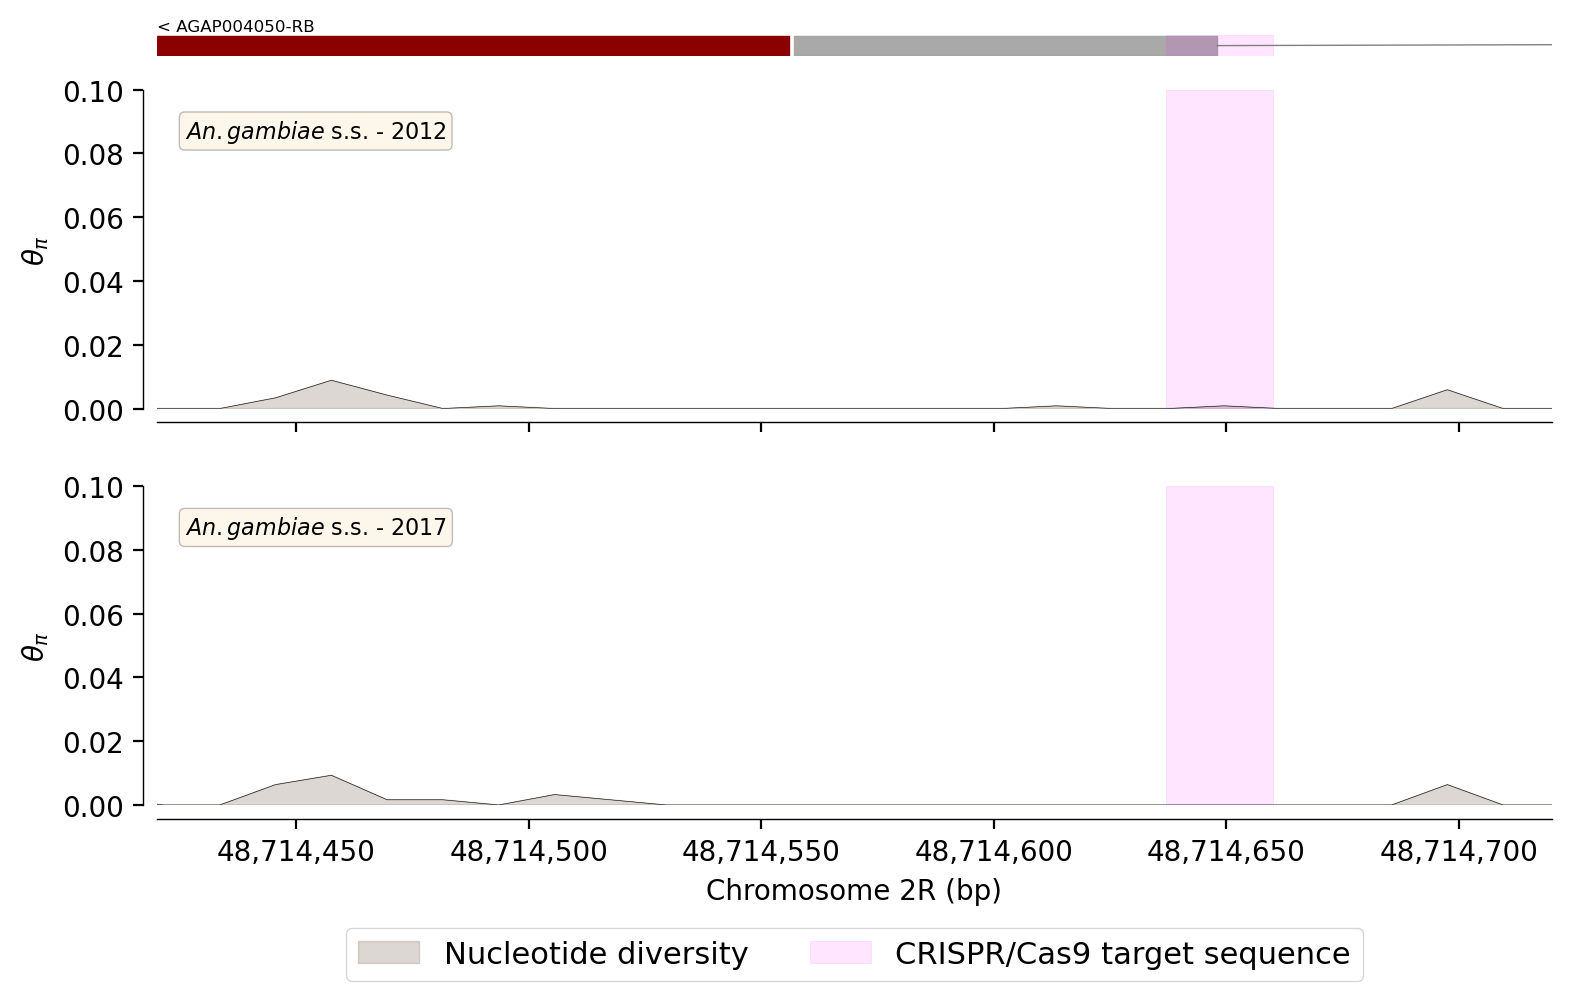

In [30]:
def fig3_density(data = dsx_RB, xlim = dsx_region, pos1=Ag_pos_2012['pos_'], ac1=Ag_gt_2012['ac'],start=48703664,
                 pos2=Ag_pos_2017['pos_'], ac2=Ag_gt_2017['ac'],stop=48792242,window_size=100, window_step=None, gd = gds,
                 ylim=None, figsize=(9, 5), exon_label='{}', stop1=None, spec_pos=None, region_name=None, int_reg=None, 
                 r1=0.1, r2=1.5, r3=1.5, r4=1.5, xtick=True, fig_name = None, av1=None, av2=None, av3=None,
                 species = '$An. gambiae$ s.s.'
                ):
    '''
    This function plot the Nucleotide diversity, conservation score, the transcript 
    on the same axe.
    '''
    gs = plt.GridSpec(nrows=4, ncols=1, height_ratios=(r1, r2, r3, r4))
    
    fig = plt.figure(figsize=figsize)
    
    # plot the gene model
    ax = fig.add_subplot(gs[0])
    plot_transcripts(data, ax=ax, xlim=xlim[1:], spec_pos=spec_pos, label_exons=f'{data.index[1]}', 
                     region_name=region_name, int_reg=int_reg, exon_label=exon_label)
    if av1:
        ax.axvspan(gd[1], gd [2], color='magenta', alpha=0.1, lw=0.3)

    #plot stop
    if stop1:
        if type(stop1) == int:
            ax.axvline(x=stop1, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
        else:
            for stop_pos in stop1[0:-1]:
                ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--')
            ax.axvline(x=stop_pos, ymin=0.3, ymax=0.8, color='red', linestyle='--', label='Stop codon')
    ax.set_xlim(*xlim[1:])
    
    # plot diversity
    ax = fig.add_subplot(gs[1])
    plot_diversity(xlim=xlim[1:], pos=pos1, ac= ac1,  window_size=window_size, start=start, stop=stop, 
                   window_step=window_step, ax=ax, ylim=ylim, xtick=False)
    if av2:
        ax.axvspan(gd[1], gd [2], color='magenta', alpha=0.1, lw=0.3)
    
    ax.text(0.02, 0.85, f'{species} - 2012', transform=ax.transAxes, size=8, 
            bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))
    
    # plot diversity
    ax = fig.add_subplot(gs[3])
    plot_diversity(xlim=xlim[1:], pos=pos2, ac= ac2,  window_size=window_size, start=start, stop=stop, 
                   window_step=window_step, ax=ax, ylim=ylim, xtick=xtick) 
    ax.set_xlabel(f'Chromosome {xlim[0]} (bp)')
    if av1:
        ax.axvspan(gd[1], gd [2], color='magenta', alpha=0.1, lw=0.3, label='CRISPR/Cas9 target sequence')
    
    ax.text(0.02, 0.85, f'{species} - 2017', transform=ax.transAxes, size=8, 
            bbox=dict(facecolor='wheat', edgecolor='black', alpha=0.25, boxstyle='round', pad=0.25))
    #save fig
    if fig_name:
        fig.savefig(f'{fig_name}', dpi=300, bbox_inches='tight')


##
fig3_density(data=dsx_RB, xlim=gd_site, figsize=(9, 5), window_size=12, exon_label='', ylim=(0,0.10), r3=0.05, 
                    av1=True, av2=True, av3=True)
plt.legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', ncol=4,  frameon=True,  fancybox=True, shadow=False)

plt.savefig('graph/fig3_Ag_pi', dpi=300, bbox_inches='tight')

C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3453390270.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transcript_data = data[:1].append(data[val:][:1].append(data[val:].query(f"Parent == '{idx}'")))
C:\Users\hp\AppData\Local\Temp\ipykernel_6768\3272417842.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(v)) for v in ax.get_xticks()])


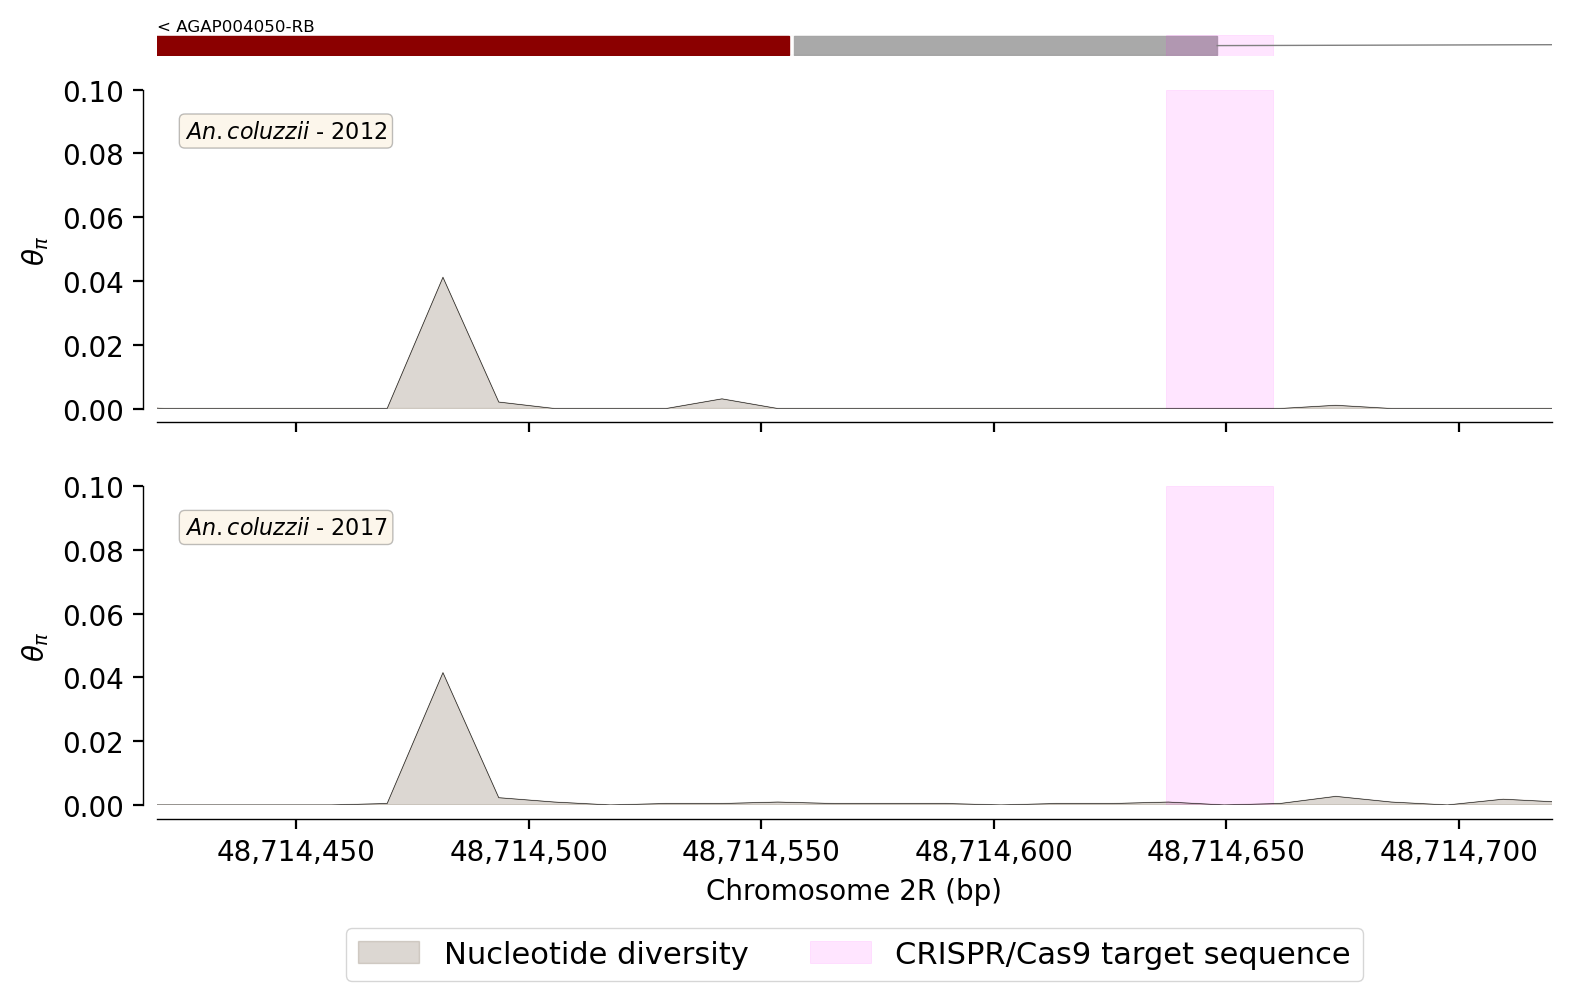

In [31]:
fig3_density(data=dsx_RB, pos1=Ac_pos_2012['pos_'], ac1=Ac_gt_2012['ac'], pos2=Ac_pos_2017['pos_'], ac2=Ac_gt_2017['ac'],
             xlim=gd_site, figsize=(9, 5), window_size=12, exon_label='', ylim=(0,0.10), r3=0.05, av1=True, av2=True, 
             av3=True, species='$An. coluzzii$')
plt.legend(bbox_to_anchor=(0.5, -0.6), loc='lower center', ncol=4,  frameon=True,  fancybox=True, shadow=False)

plt.savefig('graph/fig3_Ac_pi', dpi=300, bbox_inches='tight')